In [103]:
%reload_kedro

2023-03-11 14:49:56,063 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis
2023-03-11 14:49:56,796 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-03-11 14:49:59,555 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-03-11 14:49:59,557 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [104]:
from datetime import timedelta
import pandas as pd
from crypto_thesis.utils import build_log_return
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [105]:
plt.style.use("grayscale")
# sns.set_style("dark")

In [106]:
warnings.filterwarnings("ignore")

### Base data

In [5]:
df_prm = catalog.load("prm_binance")
df_prm.loc[:, "date"] = df_prm["open_time"].dt.date.apply(str)
df_prm = df_prm[["open_time", "date", "close", "symbol"]]
df_prm = df_prm.sort_values(by=["symbol", "open_time"])

2023-03-11 11:07:45,308 - kedro.io.data_catalog - INFO - Loading data from `prm_binance` (ParquetDataSet)...


In [6]:
df_prm_logret = df_prm.groupby("symbol").apply(build_log_return)
assert df_prm_logret["log_return"].isna().sum() == df_prm["symbol"].nunique()

In [7]:
end_date = pd.to_datetime("2023-01-31")
cutoff_3y = str((end_date - timedelta(days = 3 * 365)).date())
end_date = str(end_date.date())

In [8]:
df_prm_logret = df_prm_logret[df_prm_logret["date"] <= end_date]

In [9]:
df_prm_logret.head()

,open_time,date,close,symbol,shift,log_return
0,2018-04-17 04:00:00,2018-04-17,0.26709,ADAUSDT,NaN,NaN
1,2018-04-17 04:15:00,2018-04-17,0.26301,ADAUSDT,0.26709,-0.015394
2,2018-04-17 04:30:00,2018-04-17,0.26700,ADAUSDT,0.26301,0.015057
3,2018-04-17 04:45:00,2018-04-17,0.26664,ADAUSDT,0.26700,-0.001349
4,2018-04-17 05:00:00,2018-04-17,0.26966,ADAUSDT,0.26664,0.011262


### EDA: coins universe subset

In [11]:
df_prm_grp = df_prm_logret.groupby("symbol").agg({"date": ["min", "max"]}).reset_index()

In [12]:
df_prm_grp.columns = ["symbol", "date_min", "date_max"]

In [13]:
df_prm_grp = df_prm_grp.sort_values(by="date_min", ascending=True)

In [14]:
df_aux = df_prm_grp[(df_prm_grp["date_min"] >= cutoff_3y) | (df_prm_grp["date_max"] != end_date)]
symbols_to_delete = df_aux["symbol"].tolist()

In [15]:
df_prm_grp_drop = df_prm_grp.drop(df_aux.index)

In [16]:
print(f"Remaining symbols: {df_prm_grp_drop['symbol'].unique().tolist()}")
print(f"Remaining symbols number: {df_prm_grp_drop.shape[0]}")

Remaining symbols: ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LTCUSDT', 'ADAUSDT', 'XRPUSDT', 'XLMUSDT', 'TRXUSDT', 'ETCUSDT', 'LINKUSDT', 'XMRUSDT', 'MATICUSDT', 'ATOMUSDT', 'DOGEUSDT', 'BUSDUSDT', 'BCHUSDT']
Remaining symbols number: 16


In [17]:
df_prm_grp_drop.head()

,symbol,date_min,date_max
4,BTCUSDT,2017-08-17,2023-01-31
8,ETHUSDT,2017-08-17,2023-01-31
3,BNBUSDT,2017-11-06,2023-01-31
10,LTCUSDT,2017-12-13,2023-01-31
0,ADAUSDT,2018-04-17,2023-01-31


In [18]:
# min and max values Tron
df_prm[df_prm["symbol"] == "TRXUSDT"].agg({"close": ["min", "max"]})

,close
min,0.00711
max,0.17660


### EDA: cumulative log returns

In [19]:
df_prm_dropped = df_prm_logret[~df_prm_logret["symbol"].isin(symbols_to_delete)]
df_prm_dropped = df_prm_dropped.sort_values(by=["symbol", "open_time"])

In [20]:
assert df_prm_dropped.symbol.nunique() == 16

In [21]:
df_prm_dropped = df_prm_dropped[["open_time", "symbol", "log_return"]]

In [22]:
df_prm_dropped.head()

,open_time,symbol,log_return
0,2018-04-17 04:00:00,ADAUSDT,NaN
1,2018-04-17 04:15:00,ADAUSDT,-0.015394
2,2018-04-17 04:30:00,ADAUSDT,0.015057
3,2018-04-17 04:45:00,ADAUSDT,-0.001349
4,2018-04-17 05:00:00,ADAUSDT,0.011262


In [23]:
df_prm_dropped.loc[:, "logret_cumsum"] = df_prm_dropped.groupby("symbol")["log_return"].cumsum()
assert df_prm_dropped["symbol"].nunique() \
        == df_prm_dropped["log_return"].isna().sum() \
        == df_prm_dropped["logret_cumsum"].isna().sum()

In [24]:
df_pivot = df_prm_dropped.pivot(index="open_time", columns=["symbol"], values=["logret_cumsum"]).dropna()
df_pivot = df_pivot.droplevel(level=0, axis=1)

symbols = df_pivot.columns.tolist()
df_pivot.columns = symbols

In [25]:
# find negative and positive cumulative returns
df_tail = df_pivot.tail(1)

df_tail_negative = df_tail[df_tail < 0]
df_logret_negative = pd.melt(df_tail_negative).dropna().rename(columns={"variable": "symbol", "value": "logret"})
df_logret_negative.loc[:, "pctret"] = np.exp(df_logret_negative["logret"]) - 1

print(df_logret_negative)
print()

df_tail_positive = df_tail[df_tail > 0]
df_logret_positive = pd.melt(df_tail_positive).dropna().rename(columns={"variable": "symbol", "value": "logret"})
df_logret_positive.loc[:, "pctret"] = np.exp(df_logret_positive["logret"]) - 1

print(df_logret_positive.sort_values(by="pctret", ascending=False))

     symbol    logret    pctret
2   BCHUSDT -0.512226 -0.400840
10  LTCUSDT -1.140194 -0.680243
13  XLMUSDT -1.189098 -0.695504
15  XRPUSDT -0.863147 -0.578168

       symbol    logret      pctret
3     BNBUSDT  5.191976  178.823529
11  MATICUSDT  5.191849  178.800664
6    DOGEUSDT  3.131103   21.899225
9    LINKUSDT  2.589977   12.329471
4     BTCUSDT  1.676336    4.345934
8     ETHUSDT  1.658886    4.253456
14    XMRUSDT  1.223127    2.397795
1    ATOMUSDT  1.152160    2.165023
0     ADAUSDT  0.328616    0.389045
7     ETCUSDT  0.295544    0.343857
12    TRXUSDT  0.260126    0.297094
5    BUSDUSDT  0.000900    0.000901


### Plot cumulative curves

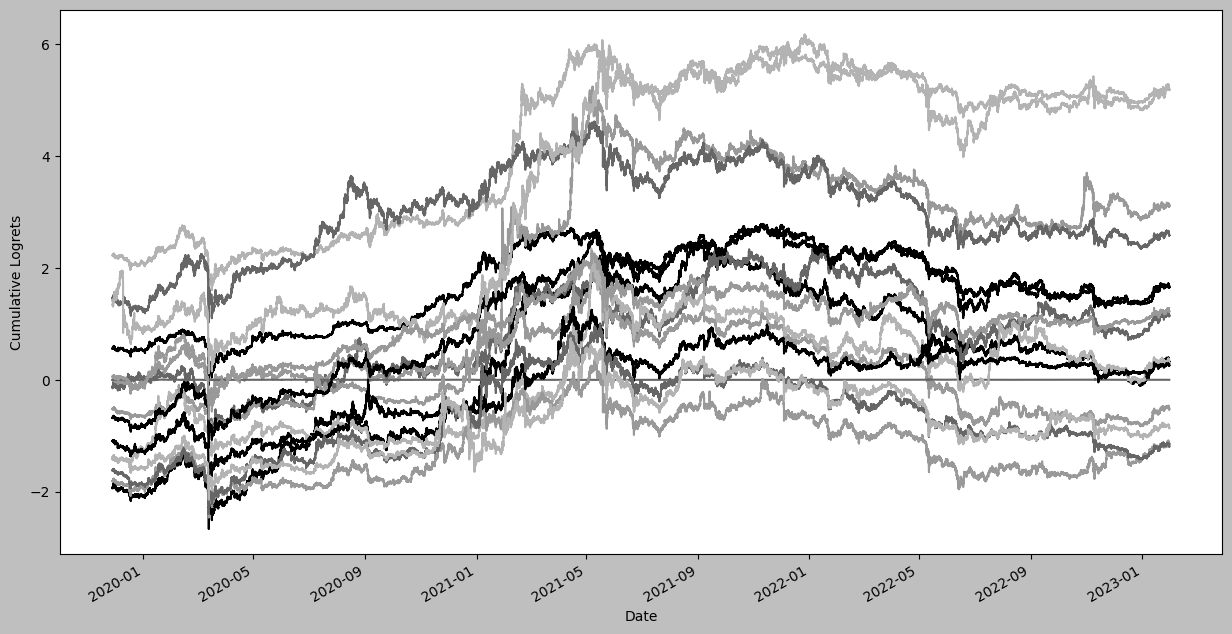

In [26]:
plot = df_pivot.plot(legend=None, figsize=(15, 8))
plot.set_xlabel("Date")
plot.set_ylabel("Cumulative Logrets")

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_cum_logrets_cryptos.png")

### EDA: log returns distribution

Building plot for: ADAUSDT
Building plot for: ATOMUSDT
Building plot for: BCHUSDT
Building plot for: BNBUSDT
Building plot for: BTCUSDT
Building plot for: BUSDUSDT
Building plot for: DOGEUSDT
Building plot for: ETCUSDT
Building plot for: ETHUSDT
Building plot for: LINKUSDT
Building plot for: LTCUSDT
Building plot for: MATICUSDT
Building plot for: TRXUSDT
Building plot for: XLMUSDT
Building plot for: XMRUSDT
Building plot for: XRPUSDT


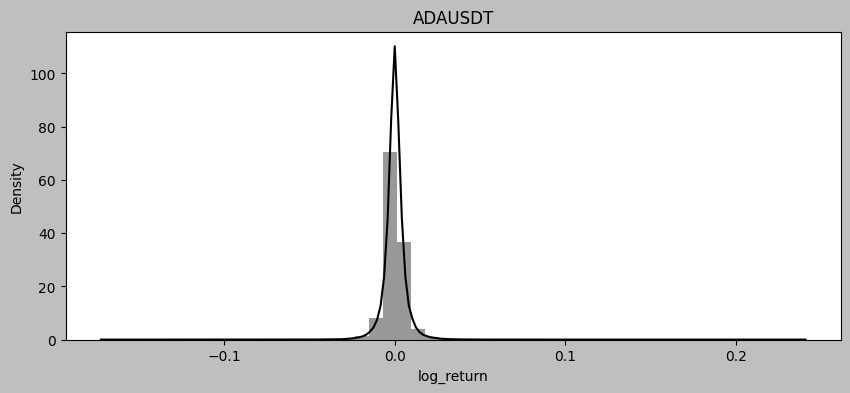

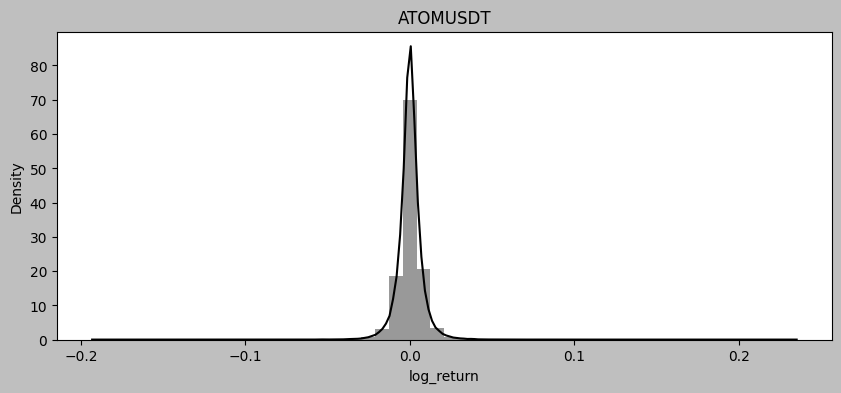

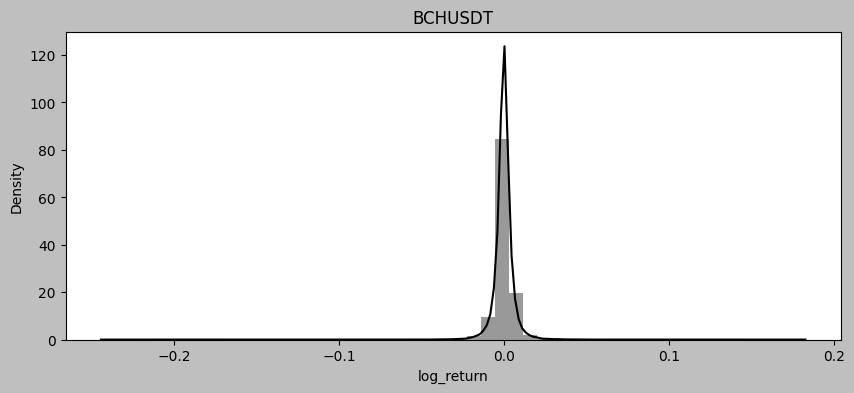

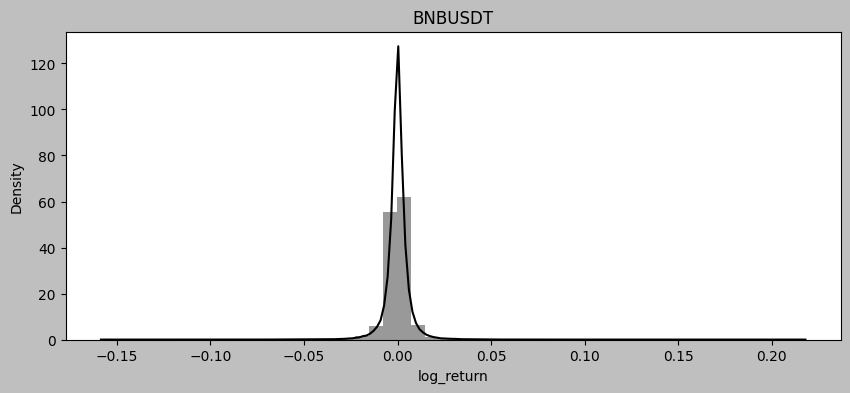

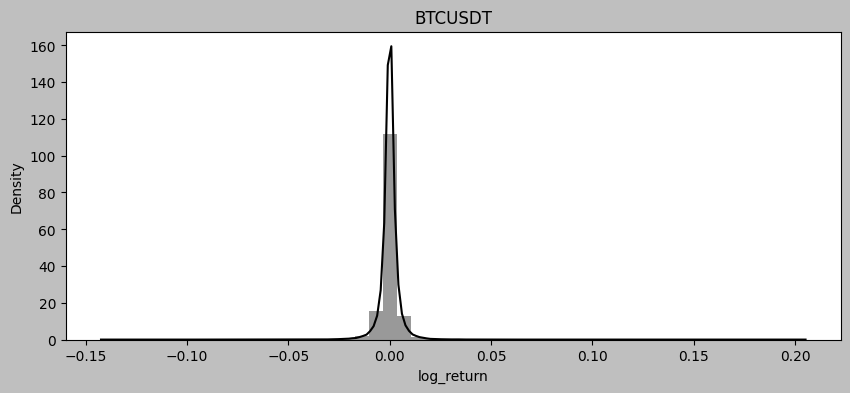

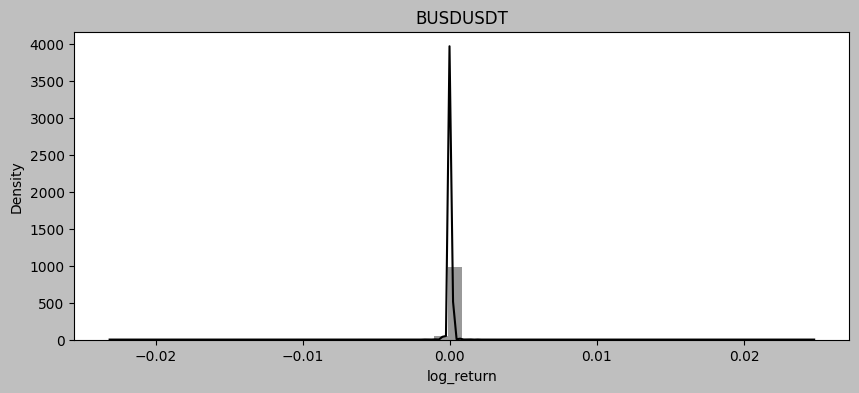

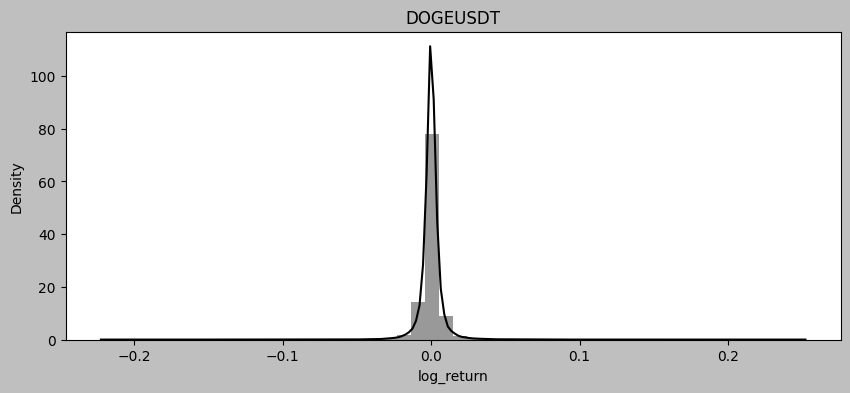

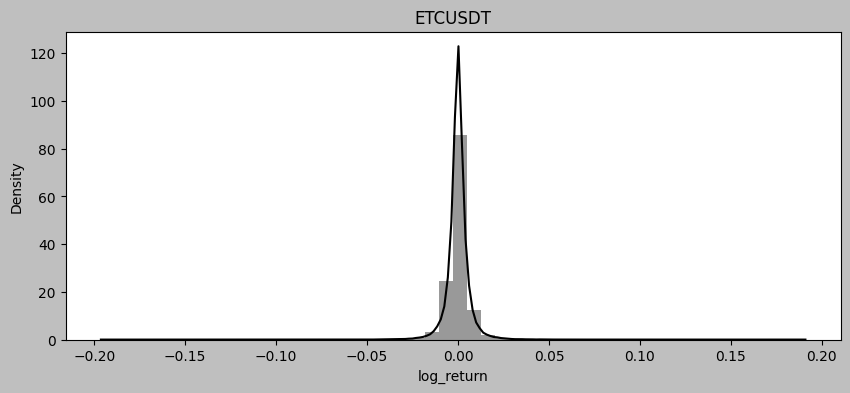

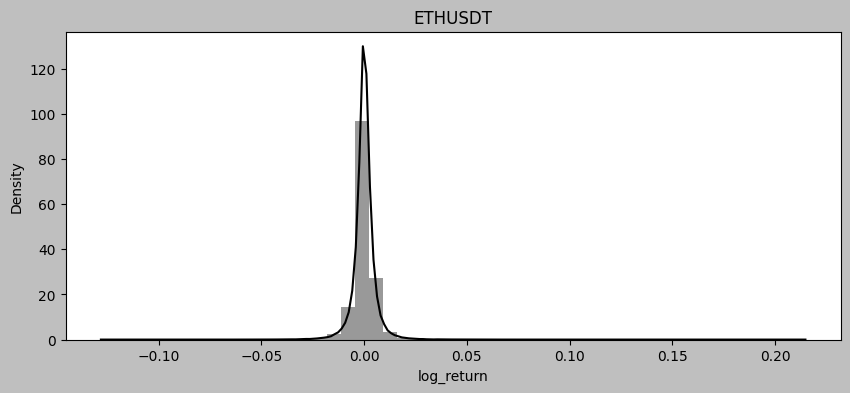

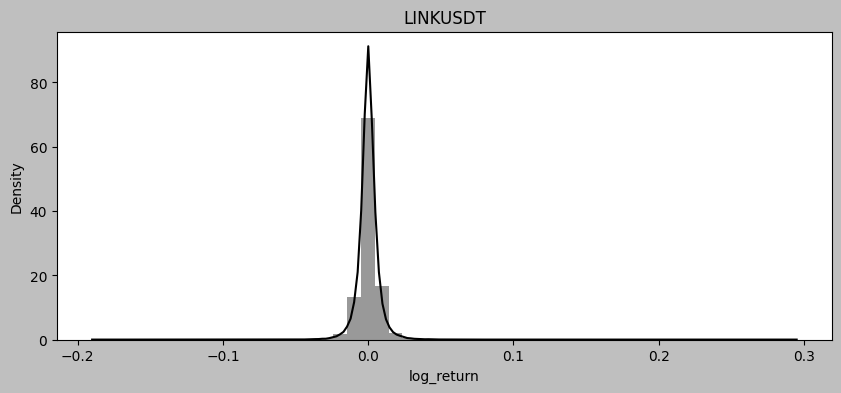

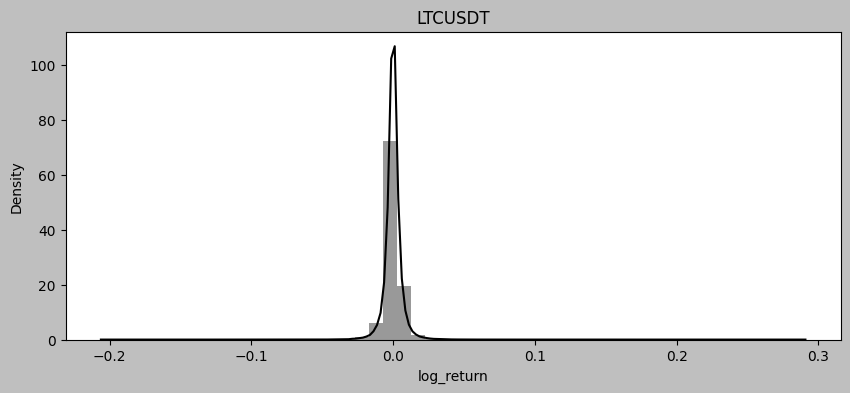

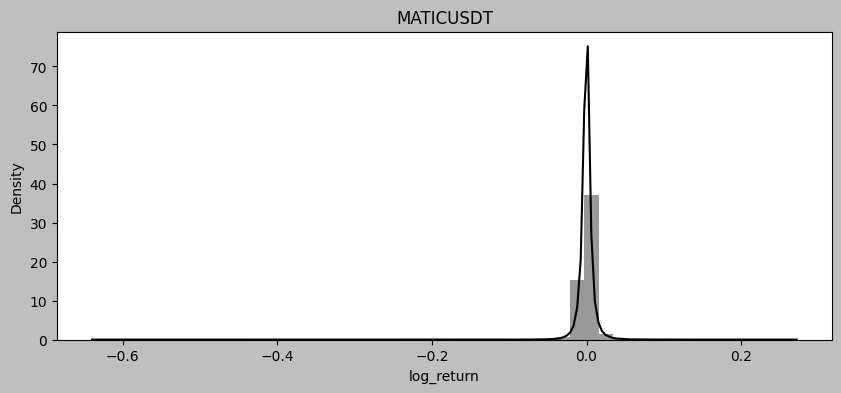

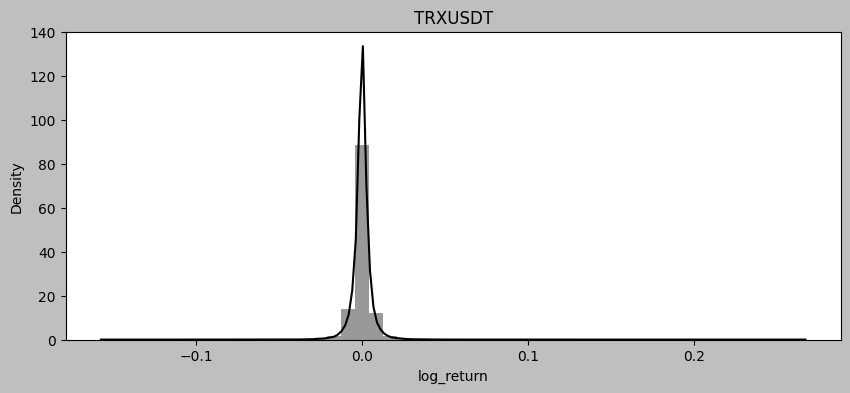

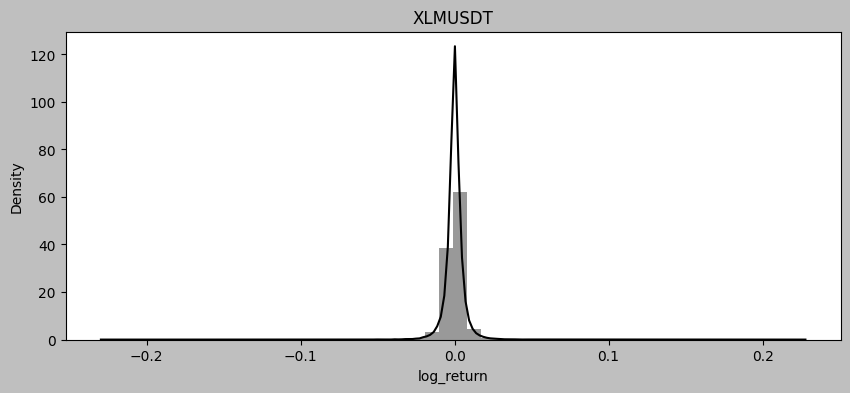

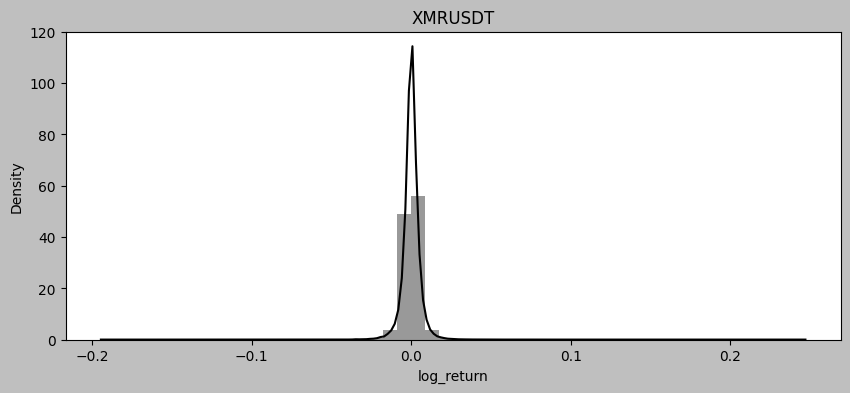

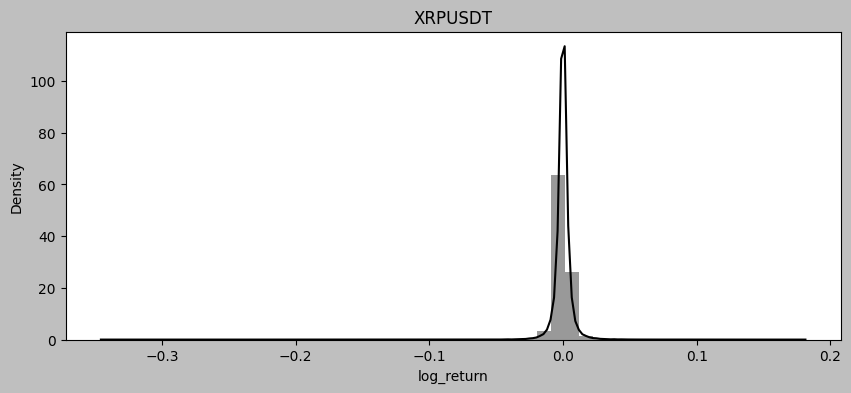

In [27]:
df_prm_dropped = df_prm_logret[~df_prm_logret["symbol"].isin(symbols_to_delete)]

for symbol in df_prm_dropped["symbol"].unique():

    print(f"Building plot for: {symbol}")
    
    df_aux = df_prm_dropped[df_prm_dropped["symbol"] == symbol][["open_time", "log_return"]]
    df_aux = df_aux.set_index("open_time").sort_index()
    
    plt.figure(figsize=(10,4))
    plt.title(symbol)
    sns.distplot(df_aux["log_return"])

### EDA: boxplot

In [28]:
df_prm_dropped = df_prm_logret[~df_prm_logret["symbol"].isin(symbols_to_delete)]

In [29]:
df_pivot = df_prm_dropped.pivot(index="open_time", columns=["symbol"], values=["log_return"]).dropna()
df_pivot = df_pivot.droplevel(level=0, axis=1)

symbols = df_pivot.columns.tolist()
df_pivot.columns = symbols

In [42]:
symbol_std_descending = df_pivot.std().reset_index().rename(columns={"index": "symbol", 0: "std"}) \
    .sort_values(by="std", ascending=False) \
    ["symbol"].tolist()

df_pivot = df_pivot[symbol_std_descending]

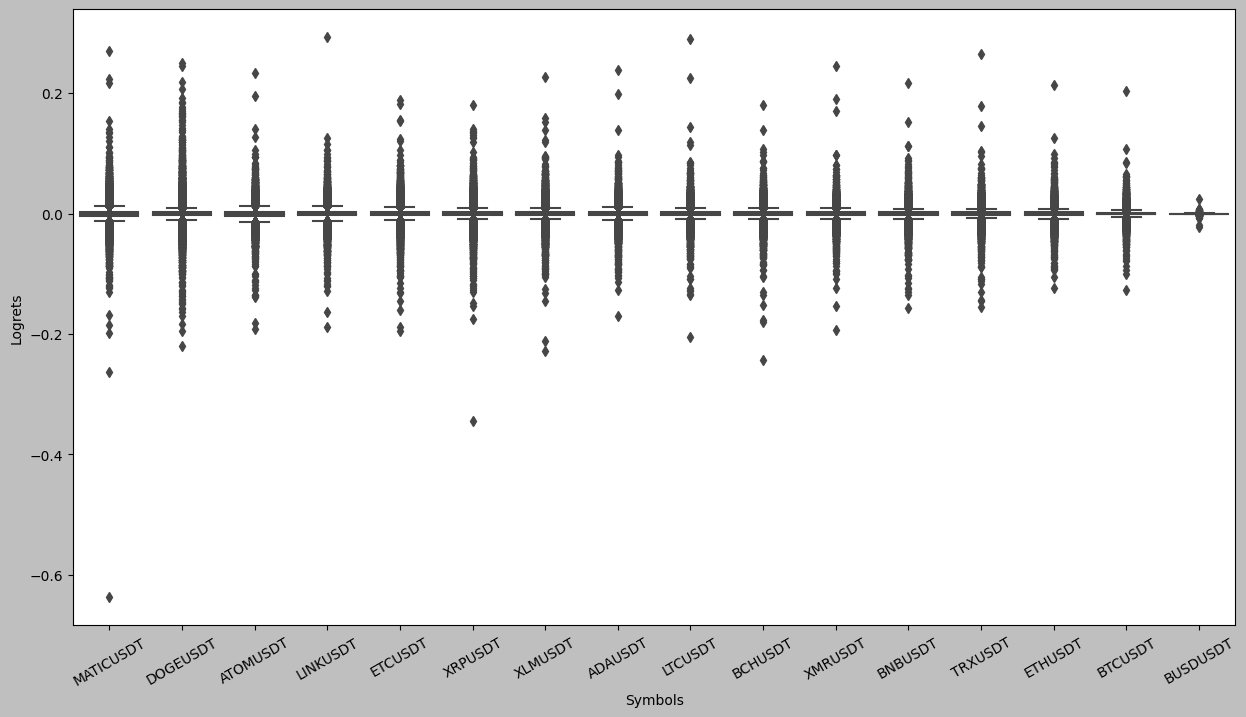

In [45]:
plt.figure(figsize=(15, 8))
plot = sns.boxplot(df_pivot)

plot.set_xlabel("Symbols")
plot.set_ylabel("Logrets")
plt.xticks(rotation = 30)

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_box_plot_cryptos.png")

### EDA: corr matrix

In [46]:
df_prm_dropped = df_prm_logret[~df_prm_logret["symbol"].isin(symbols_to_delete)]

df_pivot = df_prm_dropped.pivot(index="open_time", columns=["symbol"], values=["log_return"]).dropna()
df_pivot = df_pivot.droplevel(level=0, axis=1)

symbols = df_pivot.columns.tolist()
df_pivot.columns = symbols

In [47]:
corr_mtx = round(df_pivot.corr(), 3)
mask = np.triu(np.ones_like(corr_mtx, dtype=bool))

In [48]:
# find min and max correlation pairs
corr_mtx_parsed = corr_mtx[corr_mtx > 0].unstack().reset_index().dropna().rename(columns={0: "value"})
corr_mtx_parsed = corr_mtx_parsed[corr_mtx_parsed["value"] < 1]
corr_mtx_parsed.sort_values(by="value")

,level_0,level_1,value
107,DOGEUSDT,MATICUSDT,0.382
182,MATICUSDT,DOGEUSDT,0.382
198,TRXUSDT,DOGEUSDT,0.388
108,DOGEUSDT,TRXUSDT,0.388
246,XRPUSDT,DOGEUSDT,0.396
...,...,...,...
42,BCHUSDT,LTCUSDT,0.787
138,ETHUSDT,LTCUSDT,0.793
168,LTCUSDT,ETHUSDT,0.793
132,ETHUSDT,BTCUSDT,0.855


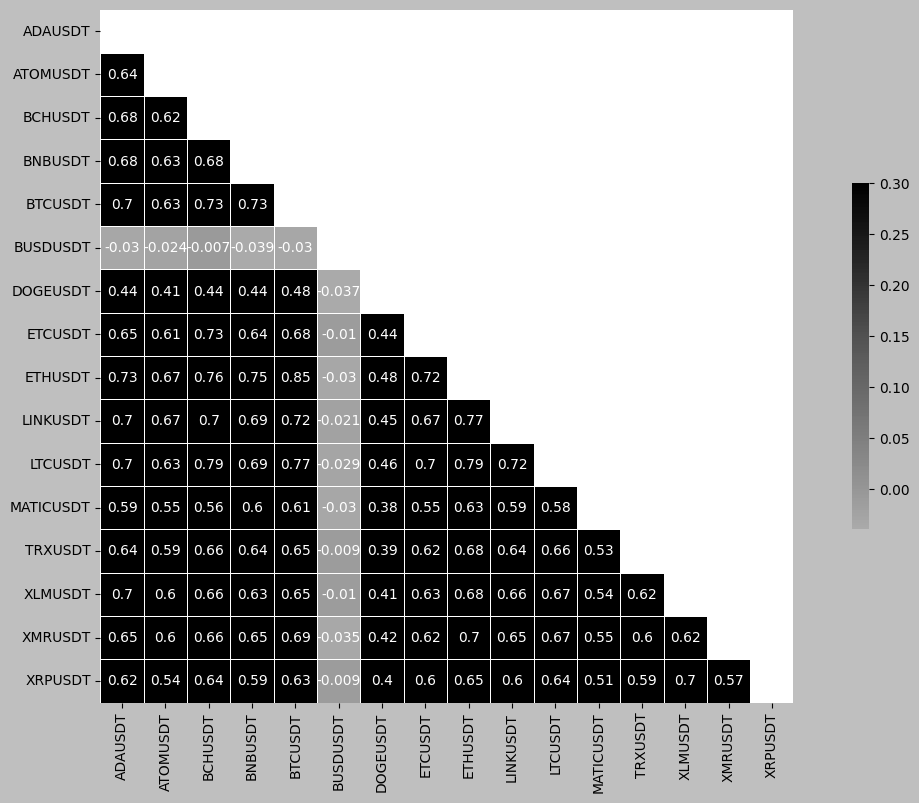

In [49]:
plt.figure(figsize=(15, 9))

plot = sns.heatmap(corr_mtx, annot=True, cmap="Greys", mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_corr_mtx_cryptos.png")

### EDA: top 5 feature importances

In [118]:
df_fte_imps = catalog.load("all_fte_imps_binance")

2023-03-11 14:51:36,555 - kedro.io.data_catalog - INFO - Loading data from `all_fte_imps_binance` (ParquetDataSet)...


In [119]:
df_fte_imps = df_fte_imps.sort_values(by="score", ascending=False).head()

In [120]:
df_fte_imps.loc[:, "features"] = df_fte_imps["features"].str.replace("log_return_mean", "logret_avg") \
                                                        .str.replace("log_return_accum", "logret_acc")

<Figure size 800x400 with 0 Axes>

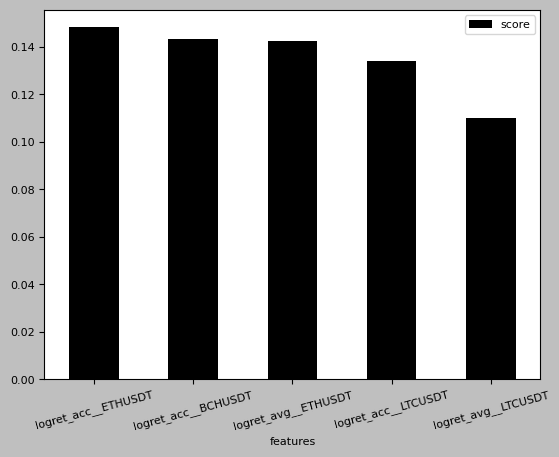

In [130]:
plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 8})

plot = df_fte_imps.set_index("features").sort_values(by="score", ascending=False).plot(kind="bar")
plt.xticks(rotation = 15)

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_top5_fte_imps.png")